In [1]:
from glob import glob
from PIL import Image

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1 import ImageGrid
from dlup.data.dataset import TiledROIsSlideImageDataset, SlideImage

In [7]:
# pmchhg/dpat/notebooks/outputs/6/PMC_HHG_36_Hersenen_I-05_8x8_200slow.png
path = "/home/sdejong/pmchhg/lightning_logs/version_2418468/output/test/PMC_HHG_9_Hersenen_I-04_8x8_200slow_output.hdf5"
f = h5py.File(path)

# Unpack hdf5.
data = {}
for k in f.keys():
    try:
        data[k] = f[k][()].decode()
    except (UnicodeDecodeError, AttributeError):
        data[k] = f[k][()]


In [8]:
img_name = path.split("/")[-1].split("_output")[0]
path = glob(f"../../images-tif/*{img_name}*")[0]
mask_path = glob(f"../../masks/*{img_name}*")[0]
img_arr = np.array(Image.open(path))
img = SlideImage.from_file_path(path)
dataset = TiledROIsSlideImageDataset.from_standard_tiling(
    path=path,
    mpp=0.2,
    tile_size=(224, 224),
    tile_overlap=(0, 0),
    tile_mode="skip",
    mask=np.array(Image.open(mask_path)),
    mask_threshold=1,
)

In [9]:
data["prediction"]

array([0.59827006])

In [10]:
X = data["tile_x"]
Y = data["tile_y"]
A = data["attention"]
T = data["tile_region_index"]
A_norm = (A - np.min(A)) / (np.max(A) - np.min(A))

# Xu = np.unique(X)
# Yu = np.unique(Y)

# A_img = np.zeros((Yu.size, Xu.size))
# T_img = np.zeros((Yu.size, Xu.size))
# for i in range(X.size):
#     A_img[np.where(Yu == Y[i]), np.where(Xu == X[i])] = A_norm[i]
#     T_img[np.where(Yu == Y[i]), np.where(Xu == X[i])] = T[i]

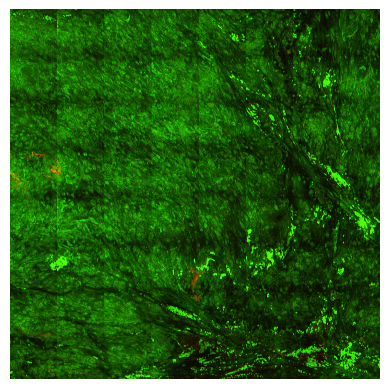

In [11]:
scaling = img.get_scaling(mpp=0.2)
crop = np.subtract(img.size, np.mod(img.size, (224, 224)))  # Crop, because of skip policy with tile making.
img_scaled_cropped = np.array(img.get_thumbnail(img.size))[:crop[1], :crop[0], :]
plt.imshow(img_scaled_cropped)
plt.axis("off")
plt.show()

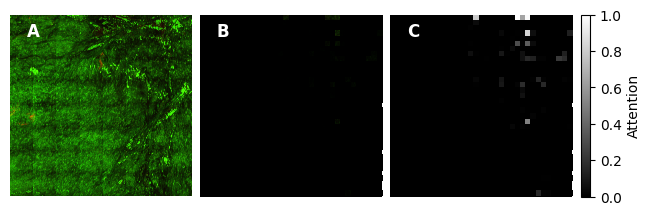

In [12]:
fig, axs = plt.subplot_mosaic([["A", "B", "C"]], layout="compressed")

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.05, 0.95, label, transform=ax.transAxes + trans,
            fontsize="large", fontweight="heavy", va="center", ha="center", color="white")

    ax.axis("off")

# Original image, cropped to maximum tile region.
axs["A"].imshow(img_scaled_cropped[::-1])

background = Image.new("RGB", img_scaled_cropped[::-1].shape[:2][::-1], (0, 0, 0))

for tile in np.array(dataset):
    coords = np.array(tile["coordinates"])
    extent = tuple(np.array((coords[0], coords[0] + 224, coords[1], coords[1] + 224)).astype(int))

    axs["B"].imshow((np.array(tile["image"]) * A_norm[np.nonzero(tile["region_index"] == T)][0]).astype(int), extent=extent, origin="lower", vmin=0, vmax=255)
    axs["B"].set_xlim(0, img_scaled_cropped.shape[1])
    axs["B"].set_ylim(0, img_scaled_cropped.shape[0])

    im = axs["C"].imshow(np.ones_like(np.array(tile["image"]))[:, :, 0] * A_norm[np.nonzero(tile["region_index"] == T)][0],  extent=extent, origin="lower", vmin=0, vmax=1, cmap="gray")
    axs["C"].set_xlim(0, img_scaled_cropped.shape[1])
    axs["C"].set_ylim(0, img_scaled_cropped.shape[0])

axs["B"].axvspan(0, img_scaled_cropped.shape[1], facecolor="black", zorder=-1)
axs["C"].axvspan(0, img_scaled_cropped.shape[1], facecolor="black", zorder=-1)

cbar = plt.colorbar(im)
cbar.set_label("Attention")

# axs["A"].set_title("Original")
# axs["B"].set_title("Attention-weighted")
# axs["C"].set_title("Annotations")

# TODO: Pathologist focus

fig.savefig(f"outputs/6/{data['case_id']}_{data['img_id']}-summary.png", bbox_inches="tight", dpi=300)

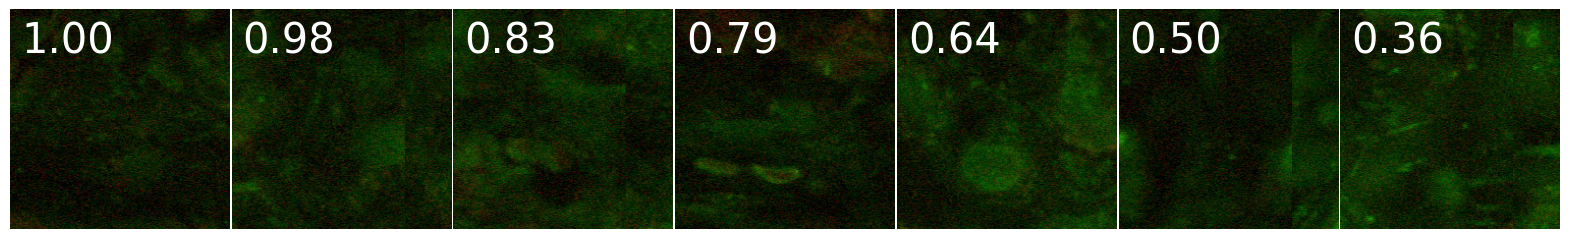

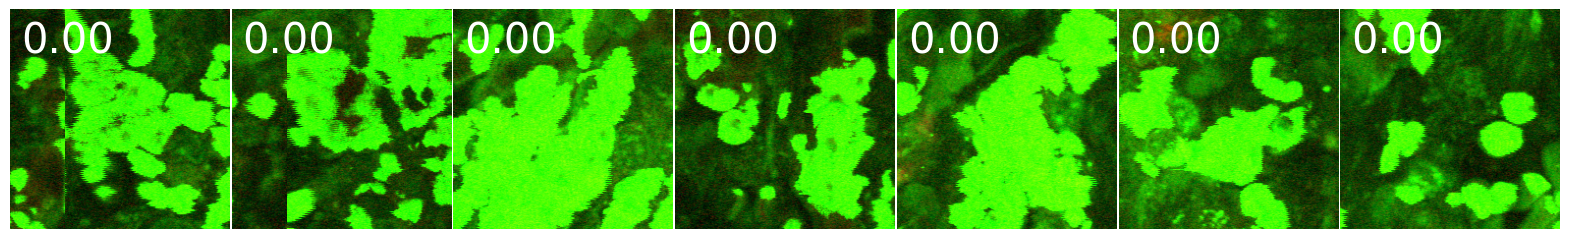

In [18]:
fig = plt.figure(figsize=(20, 5))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 7),
                #  axes_pad=0.1,
                 label_mode="L",
                 )

for ax, tile, a in zip(grid, np.array(dataset)[np.argsort(A_norm)[::-1]], A_norm[np.argsort(A_norm)[::-1]]):  # Get the tiles with highest attention.
    ax.imshow(tile["image"], origin="lower")
    ax.axis("off")
    ax.text(0.05, 0.8, f"{a:.2f}", color="white", transform=ax.transAxes, fontsize=30)
fig.savefig(f"outputs/6/{data['case_id']}_{data['img_id']}-tiles.png", bbox_inches="tight", dpi=300)

fig = plt.figure(figsize=(20, 5))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 7),
                #  axes_pad=0.1,
                 label_mode="L",
                 )

for ax, tile, a in zip(grid, np.array(dataset)[np.argsort(A_norm)[::1]], A_norm[np.argsort(A_norm)[::1]]):  # Get the tiles with highest attention.
    ax.imshow(tile["image"], origin="lower")
    ax.axis("off")
    ax.text(0.05, 0.8, f"{a:.2f}", color="white", transform=ax.transAxes, fontsize=30)
fig.savefig(f"outputs/6/{data['case_id']}_{data['img_id']}-tiles-low-a.png", bbox_inches="tight", dpi=300)

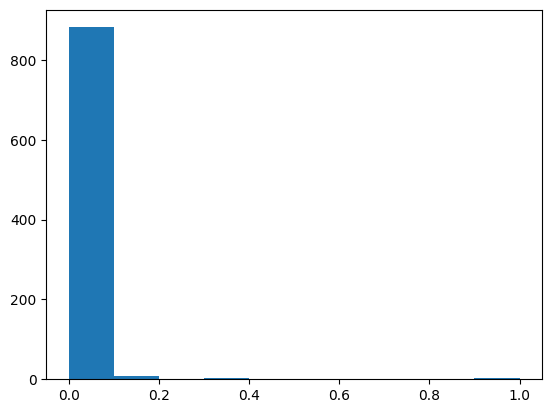

In [14]:
plt.hist(A_norm)
plt.show()